<a href="https://colab.research.google.com/github/UITTrinhQuangTruong/CS114.K21/blob/master/DetectingSarcasm_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Danh sách thành viên:

18520393 - Trịnh Quang Trường

18520158 - Phạm Xuân Thiên

##Mô tả bài toán
Phát biểu bài toán: Dựa vào tiêu đề của một bài báo, đưa ra dự đoán liệu nó có phải là một bài báo châm biếm hay không.

Data: Lấy các tiêu đề bài báo có tính châm biếm từ trang web [theOnion](https://theonion.com).
Tiêu đề bài báo không có tính châm biếm lấy tại trang web [HUFFPOST](https://huffpost.com)

Input: Tiêu đề của bài báo.

Output: Bài báo có tính châm biếm hay không

##Tải dữ liệu cần thiết

In [5]:
#Download file data của bài toán
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=103yZ1cr6HkzNPk31OyJyHneqQUCS_Rvq' -O sarcasm-detection.json

#Download file data tự crawl gồm 2 phần: File is_sacrasm chứa những title sacrasm và file non_sacrasm chứa những title không phải sarcasm.
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EeqKwZZhhGrW0V3JM4Exk1OrJk1z4g9g' -O is_sarcasm.txt

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1--ICQ3CEsGoZplkcCCrkYU73WP0zQ0Qa' -O non_sarcasm.txt

--2020-06-26 07:01:44--  https://docs.google.com/uc?export=download&id=103yZ1cr6HkzNPk31OyJyHneqQUCS_Rvq
Resolving docs.google.com (docs.google.com)... 64.233.189.102, 64.233.189.139, 64.233.189.113, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ucahv9ivienbl8c1btvr96if0e4t4ll6/1593154875000/12289657559733837223/*/103yZ1cr6HkzNPk31OyJyHneqQUCS_Rvq?e=download [following]
--2020-06-26 07:01:46--  https://doc-10-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ucahv9ivienbl8c1btvr96if0e4t4ll6/1593154875000/12289657559733837223/*/103yZ1cr6HkzNPk31OyJyHneqQUCS_Rvq?e=download
Resolving doc-10-8s-docs.googleusercontent.com (doc-10-8s-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-10-8s-docs.googleusercontent.com (doc-10-8s-d

#Chuẩn bị thư viện và dữ liệu

Khai báo thư viện

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
import tensorflow as tf

Đọc dữ liệu từ file tải về lưu trong GG Drive bằng thư viện pandas

In [4]:
import pandas as pd
# Dung pandas de doc file json

data = pd.read_json("/content/sarcasm-detection.json", lines=True)
data.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Xóa cột đường dẫn đến bài báo vì không cần thiết.

In [ ]:
del data['article_link']

Kiểm tra lại data


In [ ]:
data.head(10)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you...",0
8,top snake handler leaves sinking huckabee camp...,1
9,friday's morning email: inside trump's presser...,0


Biểu đồ thống kê số tiêu đề là châm biếm và không châm biếm

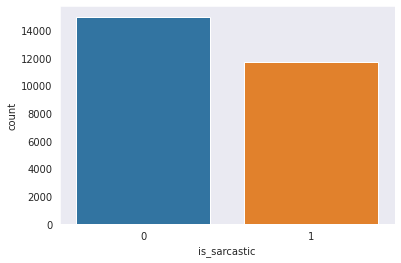

In [ ]:
sns.set_style("dark")
sns.countplot(data.is_sarcastic)

# Tiền xử lý

## StopWord là gì ?
Stopword là những từ trong câu khi mất đi không gây ảnh hưởng đến nghĩa của câu.
Ví dụ: the man is strong. -> Man is strong.

Những stopword này đã được thống kê trong corpus của thư viện nltk.


In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Xóa các stopword ra khỏi data:


In [ ]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

## Xóa tags html (nếu còn) trong headlines
Vd: h1, title

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
soup = BeautifulSoup('<title>abc<h1>sd</title>', "html.parser")
soup.text

'abcsd'

##Xóa những phần thừa trong data

Xóa nội dung trong ngoặc vuông.
\\ trong thư viện re cho phép sử dụng kí tự sau nó không mang ý nghĩa đặc biệt. Ví dụ: \\[ ~ [. Vì trong re nếu dùng kí tự '[', ']' dùng để chỉ 1 tập các kí tự. 

In [ ]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

a = 'Dectect sarcasm [part 1]'
print(a)
a = remove_between_square_brackets(a)
a

Dectect sarcasm [part 1]


'Dectect sarcasm '

Xóa URL (nếu còn)

In [ ]:
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

a = 'http\\aab vaaaaaa'
remove_between_square_brackets(a)

' vaaaaaa'

Tổng hợp lại các hàm xử lý

In [ ]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

Áp dụng hàm denoise_text cho toàn bộ cột headlines

In [ ]:
data['headline']=data['headline'].apply(denoise_text)

#Tìm hiểu và biểu diễn dữ liệu

Biểu đồ phân bố số kí tự có trong một text




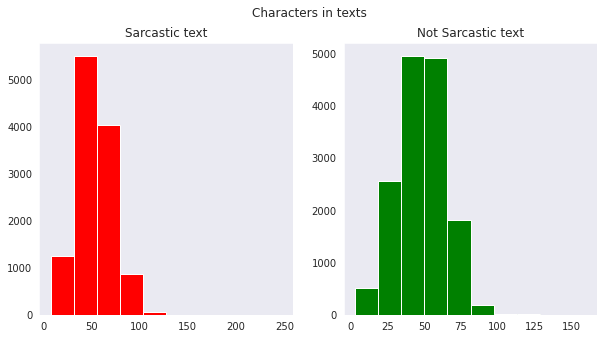

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

Biểu đồ phân bố số từ có trong một text

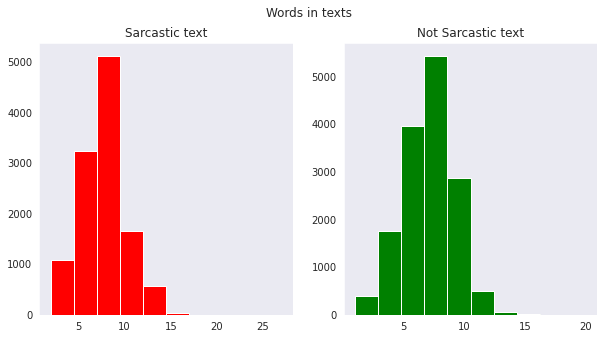

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

Độ dài trung bình của từ trong một text

Text(0.5, 0.98, 'Average word length in each text')

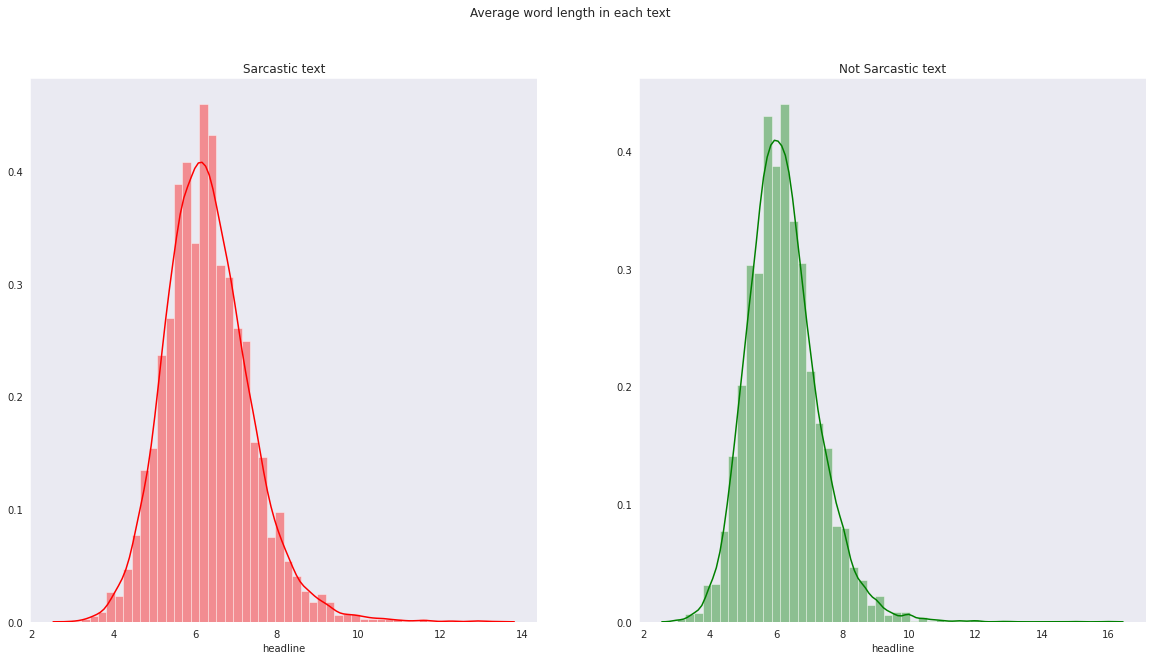

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

Nhận xét :
- Các bài báo châm biếm thường có tiêu đề dài hơn so với các bài báo thường.
- Data train khá đồng đều giữa 2 trạng thái. 

#Giới thiệu Word2Vec

Là một model unsupervised learning được training từ large corpus. Gồm 2 model là skip-gram và Cbow. Cbow có thời gian train nhanh nhưng độ chính xác không cao bằng skip-gram và ngược lại.

##Chuẩn bị trước khi training Word2Vec model 



Chuyển đổi định dạng của text qua định dạng mà gensim có thể hiểu được

In [ ]:
def split_words(headline):
  words = []
  for i in headline:
    l = []
    for j in i.split():
      l.extend(i.split())
      break
    words.append(l)
  return words

Sử dụng hàm Word2Vec để tạo ra vector biểu diễn từ. Với 36436 từ được biểu diễn trên không gian vector có 200dim

In [ ]:
import gensim
#Số chiều của không gian vector biểu diễn từ
EMBEDDING_DIM = 200

w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

print(w2v_model)

Word2Vec(vocab=36436, size=200, alpha=0.025)


##"Số hóa" tất cả các từ bằng Tokenizer


Hàm tokenizer giúp khai báo dữ liệu kiểu bảng, trong đó mỗi từ khác nhau sẽ được ký hiệu bởi số nguyên khác nhau duy nhất.

Hàm fit_on_texts giúp chúng ta xây dựng nên bảng để tương ứng từ sang các số như chúng ta cần.

In [ ]:
words = split_words(data.headline.values)
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
print(tokenizer.word_index)

{'new': 1, 'man': 2, 'trump': 3, 'one': 4, 'area': 5, 'donald': 6, 'says': 7, 'woman': 8, 'u.s.': 9, 'day': 10, 'first': 11, "trump's": 12, 'get': 13, 'report:': 14, 'like': 15, 'time': 16, 'people': 17, 'still': 18, 'obama': 19, 'make': 20, 'house': 21, 'life': 22, 'women': 23, 'white': 24, 'back': 25, 'clinton': 26, 'could': 27, 'world': 28, 'americans': 29, 'family': 30, 'way': 31, 'gop': 32, 'would': 33, 'bill': 34, '5': 35, 'best': 36, 'black': 37, 'police': 38, 'really': 39, 'years': 40, 'school': 41, "can't": 42, 'finds': 43, 'know': 44, 'death': 45, 'health': 46, 'american': 47, 'last': 48, 'going': 49, 'say': 50, "'the": 51, 'home': 52, 'things': 53, 'nation': 54, 'hillary': 55, 'may': 56, 'every': 57, 'show': 58, 'state': 59, 'campaign': 60, 'president': 61, 'year': 62, 'need': 63, 'mom': 64, 'good': 65, 'gets': 66, 'big': 67, 'getting': 68, 'watch': 69, 'love': 70, 'little': 71, 'take': 72, 'video': 73, 'parents': 74, 'makes': 75, 'kids': 76, 'calls': 77, 'party': 78, 'john'

Sau khi đã có bảng, chúng ta thực hiện chuyển từng từ thành số tương ứng ở trong tất cả các chuỗi. Hàm texts_to_sequences sẽ giúp ta làm việc này

Hàm pad_sequences tạo ra một ma trận từ một list có độ dài n. Hình dạng của ma trận đó là: (n , maxlen). Ma trận này giúp lấp đầy những khoảng trống trong list do sự chênh lệch số từ tạo ra.

In [ ]:
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)
print(tokenized_train[1])
print(x[1])
print(x.shape)

[8175, 3018, 2430, 8176, 295, 15824, 167, 1007]
[    0     0     0     0     0     0     0     0     0     0     0     0
  8175  3018  2430  8176   295 15824   167  1007]
(26709, 20)


Số từ cộng thêm 1 vì Embedding tạo thêm một vector để biểu diễn từ "UNKNOWN"

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

36437


##Tạo ma trận trọng số



Ma trận trọng số của mạng neutral có kích thước: số từ x số chiều vector

Tạo ma trận trọng số với hàm:

In [ ]:
def get_weight_matrix(model, vocab):
    #Khúc trên đã giải thích tương tự
    vocab_size = len(vocab) + 1
    #Tạo ma trận với giá trị mặc định là 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    #Hàm items giúp mapping 2 giá trị
    for word, i in vocab.items():
      weight_matrix[i] = model[word]
    #print(weight_matrix[1])
    return weight_matrix

Gọi hàm thực hiện. Với model là w2c_model và vocab là tokenizer

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Training Word2Vec model
Cuối cùng cũng đến lúc...

Neural là mô hình toán học mô phỏng nơron trong hệ thống thần kinh con người. Model đó biểu hiện cho một số chức năng của nơron(neuron) thần kinh con người. Một nhóm các neural nhân tạo (nút) nối với nhau, và xử lý thông tin bằng cách truyền theo các kết nối và tính giá trị mới tại các nút gọi là Neural Network

In [ ]:
#Định nghĩa Neural Network
model = Sequential()

model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))

#LSTM cơ chế tương tự với RNN

model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

Liệt kê qua các tầng của model sequential_2

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7287400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 7,624,553
Trainable params: 7,624,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, data.is_sarcastic ,test_size = 0.3, random_state = 0) 

In [ ]:
y = data.is_sarcastic
history = model.fit(x, y, batch_size = 128 , validation_data = (x, y) , epochs = 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26709 samples, validate on 26709 samples
Epoch 1/3
26709/26709 [==============================] - 71s 3ms/step - loss: 0.4753 - acc: 0.7685 - val_loss: 0.2015 - val_acc: 0.9415
Epoch 2/3
26709/26709 [==============================] - 69s 3ms/step - loss: 0.1537 - acc: 0.9407 - val_loss: 0.0429 - val_acc: 0.9885
Epoch 3/3
26709/26709 [==============================] - 70s 3ms/step - loss: 0.0434 - acc: 0.9846 - val_loss: 0.0126 - val_acc: 0.9973


##Xử lý data tự crawl

In [ ]:
file=open('/content/non_sarcasm.txt','r')
data2=file.read()
data2=data2.split('\n')
nunn = []
for t in data:
  nunn.append(0)
file=open('/content/is_sarcasm.txt','r')
data1=file.read()
data1=data1.split('\n')
for t in data1:
  nunn.append(1)
  data2.append(t)
s = pd.DataFrame(data2)

d = {'headline': pd.Series(data2),
     'is_sarcastic': pd.Series(nunn),
   }
da = pd.DataFrame(d)

da.head()

,headline,is_sarcastic
0,Zoomers Boast They Sabotaged Trump Rally Turno...,0
1,House Judiciary Chairman: Calls For Barr's Imp...,0
2,Millions Are Unemployed. Crises Abound. Is It ...,0
3,Investing In Harm Reduction Must Be Included I...,0
4,Trump Uses Racist Terms 'Kung Flu' And 'Chines...,0


In [ ]:
words_test = split_words(da.headline.values)
tokenizer_b = text.Tokenizer(num_words=35000)
tokenizer_b.fit_on_texts(words_test)
tokenized_test = tokenizer.texts_to_sequences(words_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen = 20)
y_test = da.is_sarcastic


##So sánh performance

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x, y)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

26709/26709 [==============================] - 16s 614us/step
Accuracy of the model on Training Data is -  99.73042607307434
2340/2340 [==============================] - 1s 627us/step
Accuracy of the model on Testing Data is -  72.8205144405365


Nhận xét: Dùng bộ dữ liệu tự crawl mang lại accuracy thấp hơn so với bộ dữ liệu gốc. Từ ~79% -> ~72%
 

#Viết ứng dụng

Dừng nhập bằng cách nhập chuỗi rỗng

In [ ]:
a = input()
x_input = []
while a:
  x_input.append(a)
  a = input()
words_app = split_words(x_input)
tokenizer_app = text.Tokenizer(num_words=35000)
tokenizer_app.fit_on_texts(words_app)
tokenized_app = tokenizer.texts_to_sequences(words_app)
x_app = sequence.pad_sequences(tokenized_app, maxlen = 20)

y_app = model.predict(x_app)

i = 0
n = len(x_app)
while i < n:
  issar = "isn't sarcastic"
  if y_app[i]:
    issar = 'is sarcastic'
  print(x_input[i], issar)
  i += 1



Florida Governor Ripped For Trying To Pin COVID-19 Spike On Hispanic Workers
Tulsa Health Official Has A Stark Wake-Up Call For People Attending Trump Rally

Florida Governor Ripped For Trying To Pin COVID-19 Spike On Hispanic Workers is sarcastic
Tulsa Health Official Has A Stark Wake-Up Call For People Attending Trump Rally is sarcastic


Tham khảo tại:

[Sarcasm Detection with GloVe/Word2Vec(83%Accuracy)](https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy)

